# 長程-建立模型-平均價格_log

In [12]:
import pandas as pd

# 讀取數據，指定「停留城市」為字串
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
dtype_spec = {"停留城市": str}
data = pd.read_csv(file_path, dtype=dtype_spec)

# drop 停留城市
data = data.drop(columns=['停留城市'])

# 檢查是否有缺失值
print(data.isnull().sum())

# 顯示艙等分類為空ㄉ資料
print(data[data['隨機購買平均價格'].isnull()])

# 顯示是否為平日的各數量
print(data['是否為平日'].value_counts())

出發日期                   0
出發時間                   0
出發時段                   0
星期                     0
出發機場代號                 0
抵達時間                   0
抵達時段                   0
抵達機場代號                 0
航空公司                   0
航空公司（主航段）            380
航空公司組合                 0
航空聯盟                   0
停靠站數量                  0
停留時間                   0
停留時間_分鐘                0
飛行時間                   0
飛行時間_分鐘                0
是否過夜                   0
是否為平日                  0
機型                     2
機型（主航段）              922
機型分類                   0
航班代碼                   0
航班代碼（主航段）            920
艙等                     0
艙等分類                   0
假期                     0
艙等（主航段）              866
第一段飛行時間              923
第二段飛行時間              923
飛行時間兩段分類               0
平均價格                   0
最低價格                   0
中位數價格                  0
價格變異                   0
隨機購買平均價格               0
最低價格剩餘天數               0
筆數                     0
平均價格_log               0
最低價格_log               0


**特徵重要性**

Average Performance over 5 runs:
RandomForest:
  MSE = 0.0404
  R^2 = 0.9368
  RMSE = 0.2009
  Adjusted R^2 = 0.9367
XGBoost:
  MSE = 0.0620
  R^2 = 0.9030
  RMSE = 0.2490
  Adjusted R^2 = 0.9029


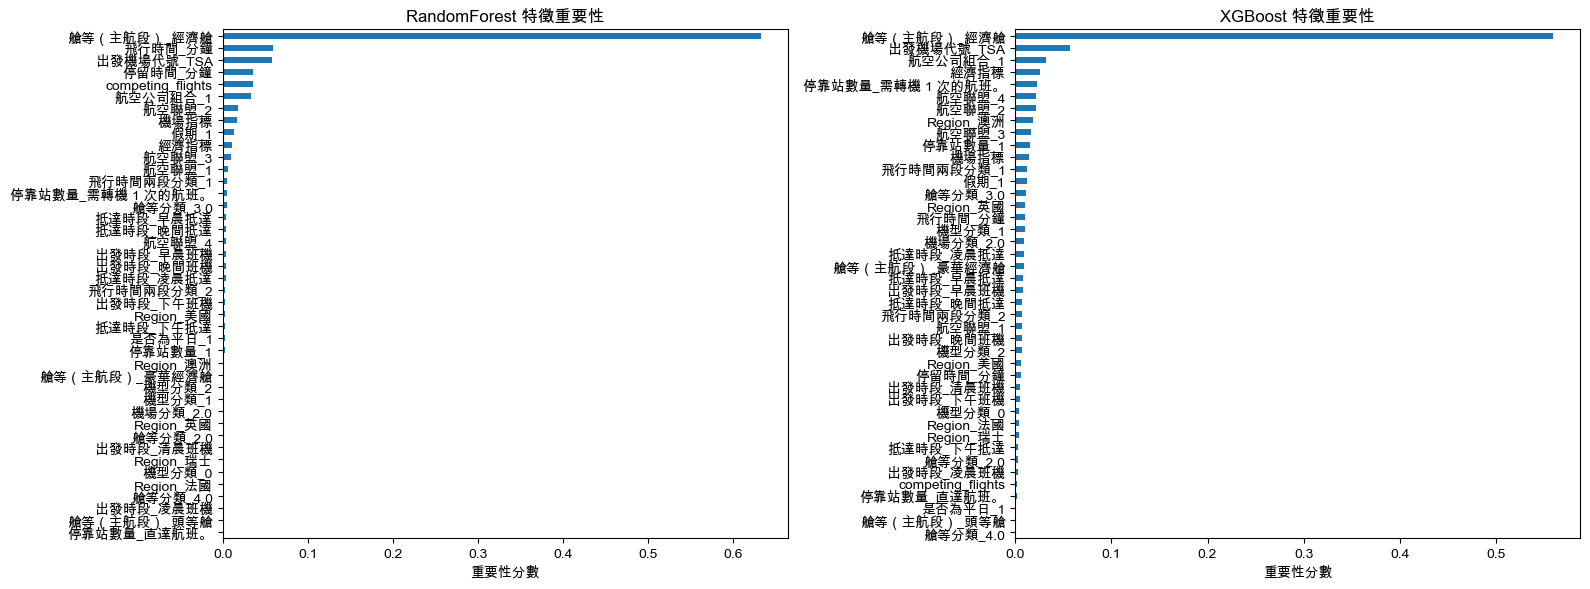

In [7]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 讀取數據，指定「停留城市」為字串
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
dtype_spec = {"停留城市": str}
data = pd.read_csv(file_path, dtype=dtype_spec)

# One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '機場分類', '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜',
                    '是否為平日', '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等（主航段）', '艙等分類']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵：先挑選 dummy 欄位，再加上數值型特徵
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '機場分類_', 
                   '飛行時間兩段分類_', '艙等（主航段）_', '艙等分類_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["平均價格_log"]

# 定義單次運行的函數，針對一個隨機種子進行資料分割、模型訓練、評估與特徵重要性計算
def run_model(seed):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}
    feature_importance = {}
    
    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    # 提取隨機森林特徵重要性
    rf_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    feature_importance['RandomForest'] = rf_importance
    
    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                             random_state=seed, n_jobs=-1, verbosity=0)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    # 提取 XGBoost 特徵重要性
    xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    feature_importance['XGBoost'] = xgb_importance

    return result, feature_importance

# 設定要運行的隨機種子數量
seeds = [123, 234, 345, 456, 567]

# 平行化運算每個隨機種子下的結果
all_results = Parallel(n_jobs=-1)(delayed(run_model)(seed) for seed in seeds)

# 整理三個模型各自的結果
results = {
    'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
}
all_feature_importance = {'RandomForest': [], 'XGBoost': []}

for res, feat_imp in all_results:
    for model in results.keys():
        results[model]['MSE'].append(res[model]['MSE'])
        results[model]['R2'].append(res[model]['R2'])
        results[model]['RMSE'].append(res[model]['RMSE'])
        results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])
    # 收集每個隨機種子下的特徵重要性 (僅收集 RF 與 XGB)
    all_feature_importance['RandomForest'].append(feat_imp['RandomForest'])
    all_feature_importance['XGBoost'].append(feat_imp['XGBoost'])

# 計算各模型的平均結果
avg_results = {}
for model, metrics in results.items():
    avg_results[model] = {
        'Average MSE': np.mean(metrics['MSE']),
        'Average R2': np.mean(metrics['R2']),
        'Average RMSE': np.mean(metrics['RMSE']),
        'Average Adjusted_R2': np.mean(metrics['Adjusted_R2'])
    }

# 顯示結果
print("Average Performance over {} runs:".format(len(seeds)))
for model, scores in avg_results.items():
    print(f"{model}:")
    print(f"  MSE = {scores['Average MSE']:.4f}")
    print(f"  R^2 = {scores['Average R2']:.4f}")
    print(f"  RMSE = {scores['Average RMSE']:.4f}")
    print(f"  Adjusted R^2 = {scores['Average Adjusted_R2']:.4f}")

# 畫圖：以隨機種子 123 的結果為例，繪製 RandomForest 與 XGBoost 的特徵重要性
rf_importance = all_feature_importance['RandomForest'][0]
xgb_importance = all_feature_importance['XGBoost'][0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RandomForest 特徵重要性圖
rf_importance.sort_values().plot(kind='barh', ax=axes[0])
axes[0].set_title("RandomForest 特徵重要性")
axes[0].set_xlabel("重要性分數")

# XGBoost 特徵重要性圖
xgb_importance.sort_values().plot(kind='barh', ax=axes[1])
axes[1].set_title("XGBoost 特徵重要性")
axes[1].set_xlabel("重要性分數")

plt.tight_layout()
plt.show()

**5次平均**

In [9]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# 讀取數據，指定「停留城市」為字串
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
dtype_spec = {"停留城市": str}
data = pd.read_csv(file_path, dtype=dtype_spec)

# One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '機場分類', '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜',
                    '是否為平日', '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等（主航段）', '艙等分類']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵：先挑選 dummy 欄位，再加上數值型特徵
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '機場分類_', 
                   '飛行時間兩段分類_', '艙等（主航段）_', '艙等分類_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["平均價格_log"]

# 定義單次運行的函數，針對一個隨機種子進行資料分割、模型訓練與評估
def run_model(seed):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}
    
    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    
    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                             random_state=seed, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    
    # SVR
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}
    
    return result

# 設定要運行的隨機種子數量
seeds = [123, 234, 345, 456, 567]

# 平行化運算每個隨機種子下的結果
all_results = Parallel(n_jobs=-1)(delayed(run_model)(seed) for seed in seeds)

# 整理三個模型各自的結果
results = {
    'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
}

for res in all_results:
    for model in results.keys():
        results[model]['MSE'].append(res[model]['MSE'])
        results[model]['R2'].append(res[model]['R2'])
        results[model]['RMSE'].append(res[model]['RMSE'])
        results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])

# 計算各模型的平均結果
avg_results = {}
for model, metrics in results.items():
    avg_results[model] = {
        'Average MSE': np.mean(metrics['MSE']),
        'Average R2': np.mean(metrics['R2']),
        'Average RMSE': np.mean(metrics['RMSE']),
        'Average Adjusted_R2': np.mean(metrics['Adjusted_R2'])
    }

# 顯示結果
print("Average Performance over {} runs:".format(len(seeds)))
for model, scores in avg_results.items():
    print(f"{model}:")
    print(f"  MSE = {scores['Average MSE']:.4f}")
    print(f"  R^2 = {scores['Average R2']:.4f}")
    print(f"  RMSE = {scores['Average RMSE']:.4f}")
    print(f"  Adjusted R^2 = {scores['Average Adjusted_R2']:.4f}")

ValueError: Input X contains NaN.
SVR does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [10]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# 讀取數據，指定「停留城市」為字串
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_outlier_final.csv'
dtype_spec = {"停留城市": str}
data = pd.read_csv(file_path, dtype=dtype_spec)

# One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '機場分類', '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜',
                    '是否為平日', '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等（主航段）', '艙等分類']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', 'Cost of Living Index',
            'GDP (PPP) per capita (in thousand USD)', 'competing_flights']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵：先挑選 dummy 欄位，再加上數值型特徵
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '機場分類_', 
                   '飛行時間兩段分類_', '艙等（主航段）_', '艙等分類_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["平均價格_log"]

# 定義單次運行的函數，針對一個隨機種子進行資料分割、模型訓練與評估
def run_model(seed):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}
    
    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    
    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                             random_state=seed, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    
    # SVR
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}
    
    return result

# 設定要運行的隨機種子數量
seeds = [123, 234, 345, 456, 567]

# 平行化運算每個隨機種子下的結果
all_results = Parallel(n_jobs=-1)(delayed(run_model)(seed) for seed in seeds)

# 整理三個模型各自的結果
results = {
    'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
}

for res in all_results:
    for model in results.keys():
        results[model]['MSE'].append(res[model]['MSE'])
        results[model]['R2'].append(res[model]['R2'])
        results[model]['RMSE'].append(res[model]['RMSE'])
        results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])

# 計算各模型的平均結果
avg_results = {}
for model, metrics in results.items():
    avg_results[model] = {
        'Average MSE': np.mean(metrics['MSE']),
        'Average R2': np.mean(metrics['R2']),
        'Average RMSE': np.mean(metrics['RMSE']),
        'Average Adjusted_R2': np.mean(metrics['Adjusted_R2'])
    }

# 顯示結果
print("Average Performance over {} runs:".format(len(seeds)))
for model, scores in avg_results.items():
    print(f"{model}:")
    print(f"  MSE = {scores['Average MSE']:.4f}")
    print(f"  R^2 = {scores['Average R2']:.4f}")
    print(f"  RMSE = {scores['Average RMSE']:.4f}")
    print(f"  Adjusted R^2 = {scores['Average Adjusted_R2']:.4f}")

ValueError: Input X contains NaN.
SVR does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

**30次平均**

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import gc

# 讀取數據，指定「停留城市」為字串
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
dtype_spec = {"停留城市": str}
data = pd.read_csv(file_path, dtype=dtype_spec)

# One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '機場分類', '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜',
                    '是否為平日', '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等（主航段）']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', 'Cost of Living Index',
            'GDP (PPP) per capita (in thousand USD)', 'competing_flights']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '機場分類_', 
                   '飛行時間兩段分類_', '艙等（主航段）_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['停留時間_分鐘', '飛行時間_分鐘', 'Cost of Living Index', 
                             'GDP (PPP) per capita (in thousand USD)', 'competing_flights']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["平均價格_log"]

# 定義單次運行的函數，針對一個隨機種子進行資料分割、模型訓練與評估
def run_model(seed):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}
    
    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=2)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    
    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                             random_state=seed, n_jobs=2, tree_method='hist')
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    
    # SVR
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}
    
    # 每次任務結束後嘗試釋放記憶體
    gc.collect()
    return result

# 定義運行次數與隨機種子列表
n_runs = 30
seeds = list(range(n_runs))

# 平行化運算，設定 timeout 為 300 秒（根據需要可調整），並降低 n_jobs
all_results = Parallel(n_jobs=2, timeout=300)(delayed(run_model)(seed) for seed in seeds)

# 整理三個模型各自的結果
results = {
    'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
}

for res in all_results:
    for model in results.keys():
        results[model]['MSE'].append(res[model]['MSE'])
        results[model]['R2'].append(res[model]['R2'])
        results[model]['RMSE'].append(res[model]['RMSE'])
        results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])

# 計算各模型的平均結果
avg_results = {}
for model, metrics in results.items():
    avg_results[model] = {
        'Average MSE': np.mean(metrics['MSE']),
        'Average R2': np.mean(metrics['R2']),
        'Average RMSE': np.mean(metrics['RMSE']),
        'Average Adjusted_R2': np.mean(metrics['Adjusted_R2'])
    }

# 顯示結果
print("Average Performance over {} runs:".format(len(seeds)))
for model, scores in avg_results.items():
    print(f"{model}:")
    print(f"  MSE = {scores['Average MSE']:.4f}")
    print(f"  R^2 = {scores['Average R2']:.4f}")
    print(f"  RMSE = {scores['Average RMSE']:.4f}")
    print(f"  Adjusted R^2 = {scores['Average Adjusted_R2']:.4f}")

Average Performance over 30 runs:
RandomForest:
  MSE = 0.0296
  R^2 = 0.9517
  RMSE = 0.1721
  Adjusted R^2 = 0.9516
XGBoost:
  MSE = 0.0511
  R^2 = 0.9167
  RMSE = 0.2260
  Adjusted R^2 = 0.9166
SVR:
  MSE = 0.0527
  R^2 = 0.9140
  RMSE = 0.2296
  Adjusted R^2 = 0.9139


**視覺化**

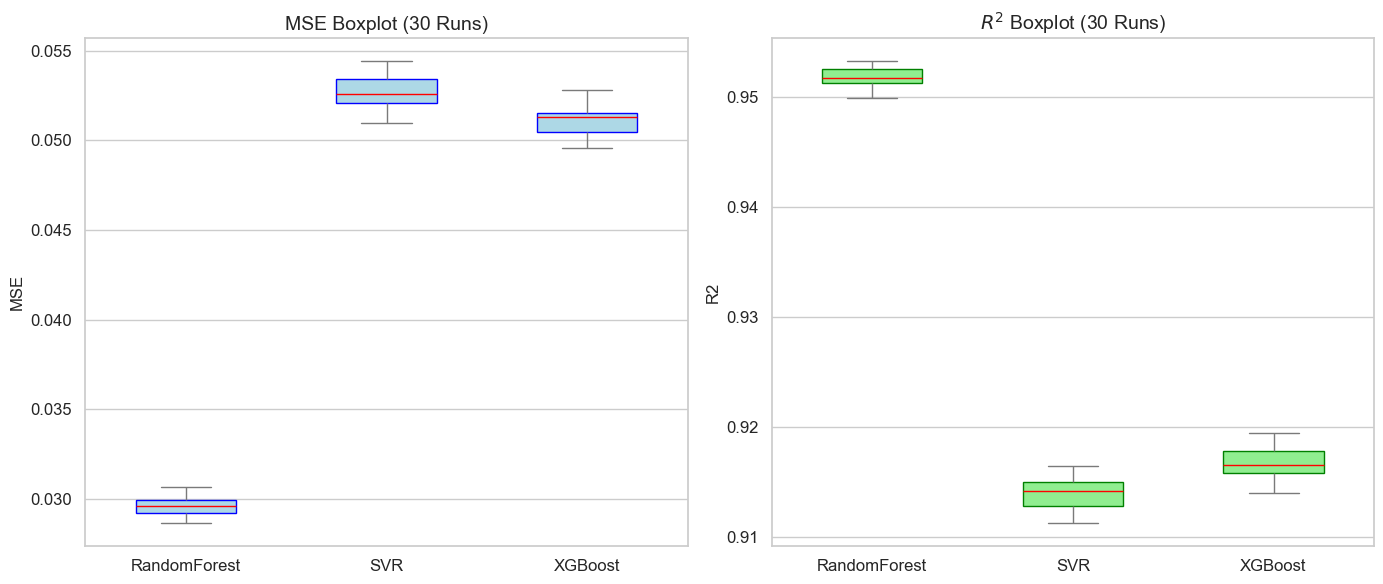

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 假設 results 字典已包含各模型 30 次的結果
# 轉換資料格式
mse_df = pd.DataFrame({
    'RandomForest': results['RandomForest']['MSE'],
    'SVR': results['SVR']['MSE'],
    'XGBoost': results['XGBoost']['MSE']
})
r2_df = pd.DataFrame({
    'RandomForest': results['RandomForest']['R2'],
    'SVR': results['SVR']['R2'],
    'XGBoost': results['XGBoost']['R2']
})

# 使用 melt 將資料轉為長格式 (long-form)
mse_long = mse_df.melt(var_name='Model', value_name='MSE')
r2_long = r2_df.melt(var_name='Model', value_name='R2')

# 設定 Seaborn 主題
sns.set(style='whitegrid', palette='pastel')

# 建立圖形
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MSE 盒鬚圖
sns.boxplot(x='Model', y='MSE', data=mse_long, ax=axes[0],
            width=0.5, showfliers=True, 
            boxprops={'facecolor':'lightblue', 'edgecolor':'blue'},
            medianprops={'color': 'red'})
axes[0].set_title('MSE Boxplot (30 Runs)', fontsize=14)
axes[0].set_xlabel('')
axes[0].tick_params(labelsize=12)

# R^2 盒鬚圖
sns.boxplot(x='Model', y='R2', data=r2_long, ax=axes[1],
            width=0.5, showfliers=True,
            boxprops={'facecolor':'lightgreen', 'edgecolor':'green'},
            medianprops={'color': 'red'})
axes[1].set_title('$R^2$ Boxplot (30 Runs)', fontsize=14)
axes[1].set_xlabel('')
axes[1].tick_params(labelsize=12)

plt.tight_layout()
plt.show()

**預測價格-隨機森林**

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import gc

# 1. 讀取數據，指定「停留城市」為字串
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
dtype_spec = {"停留城市": str}
data = pd.read_csv(file_path, dtype=dtype_spec)

# 若你的資料有日期欄位，請確認資料已依日期排序，範例如下：
data['出發日期'] = pd.to_datetime(data['出發日期'])
data.sort_values(by='出發日期', inplace=True)

# 2. One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '機場分類', '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜',
                    '是否為平日', '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等（主航段）']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 3. 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', 'Cost of Living Index',
            'GDP (PPP) per capita (in thousand USD)', 'competing_flights']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 4. 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '機場分類_', 
                   '飛行時間兩段分類_', '艙等（主航段）_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['停留時間_分鐘', '飛行時間_分鐘', 'Cost of Living Index', 
                             'GDP (PPP) per capita (in thousand USD)', 'competing_flights']

# 5. 定義自變數與目標變數
X = data[feature_cols]
y = data["平均價格_log"]

# 6. 根據日期先後劃分資料
# 假設資料是依日期從舊到新排序，前70%作為訓練集，後30%作為測試集
split_index = int(0.7 * len(data))
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

X_train = train_data[feature_cols]
y_train = train_data["平均價格_log"]
X_test = test_data[feature_cols]
y_test = test_data["平均價格_log"]

# 7. 重新訓練最終模型（以隨機森林為例）
final_rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=2)
final_rf_model.fit(X_train, y_train)

# 8. 評估模型表現（選擇性步驟）
y_pred_rf = final_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
n_test = len(y_test)
p = X.shape[1]
adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
print("Random Forest 在測試集上的表現：")
print(f"MSE: {mse_rf:.4f}")
print(f"R^2: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"Adjusted R^2: {adjusted_r_rf:.4f}")

# 9. 儲存訓練好的模型
dump(final_rf_model, 'final_rf_model.joblib')
print("隨機森林模型已儲存為 'final_rf_model.joblib'.")

# 10. 載入模型並進行預測（範例）

# 讀入excel as new data
new_data = pd.read_excel('/Users/yuchingchen/Documents/專題/cleaned_data/data/long/sydney.csv')

# 確保 new_data 只保留用來預測的特徵欄位
new_data_features = new_data[feature_cols]

# 載入先前儲存好的模型（例如 final_rf_model.joblib）
loaded_model = load('final_rf_model.joblib')

# 進行預測
predictions_log = loaded_model.predict(new_data_features)

# 如果「平均價格_log」為對數轉換後的結果，則反轉換回原始價格
predictions = np.exp(predictions_log)

# 顯示預測結果
print("隨機抽取 1000 筆資料的預測價格：")
print(predictions)

Random Forest 在測試集上的表現：
MSE: 0.0467
R^2: 0.9310
RMSE: 0.2162
Adjusted R^2: 0.9309
隨機森林模型已儲存為 'final_rf_model.joblib'.
隨機抽取 1000 筆資料的預測價格：
[103395.06369259  89920.06508065  27639.69749434  22803.42610527
 118295.08474109  22927.96216727 179562.02889    136053.02793373
 111184.9155424   85544.87482969  25370.05401666  30228.03246064
  85333.29623095 311098.89283725  94216.44304977  34438.45587977
  27822.72281699 132744.52119698  24377.03224798 120132.4304088
  24248.59432173  40424.85105657  65568.45563108 115377.73382704
 102631.48130645 101628.06436006  29556.23503295  36660.03587572
  88299.23003394 156978.00082536 117505.43538943  36522.51382961
  87330.05891216  32620.62382514  26144.13078151 109491.52261547
  37379.58579416 116996.58203768  25535.37436929  34524.68591628
  88144.4252722   27787.55263259  17789.1741448  134032.48836074
  19099.96280531 101423.00098334  97689.56248195 225039.97528376
  16670.37733583 129143.78392022  64684.91713736  28037.55106114
  19078.91670011  